<a href="https://colab.research.google.com/github/s-shahd-h/Brain-tumor-MRI-classification/blob/main/mobileNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tombackert/brain-tumor-mri-data")

print("Path to dataset files:", path)

100%|██████████| 151M/151M [00:01<00:00, 139MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1


In [ ]:
print("Contents of the base path:")
print(os.listdir(path))

Contents of the base path:
['brain-tumor-mri-dataset']


In [ ]:
dataset_path = os.path.join(path, "brain-tumor-mri-dataset")

# Check the contents of the dataset folder
print("Contents of 'Lung Disease Dataset':")
classes =os.listdir(dataset_path)
print(classes)

Contents of 'Lung Disease Dataset':
['meningioma', 'pituitary', 'glioma', 'notumor']


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directories for train and test splits
train_dir = "dataset/train"
test_dir = "dataset/test"

# Create train and test directories with subfolders for each class
for directory in [train_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

# Split the data for each class
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    # Split images into train and test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Move images to train directory
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name))

    # Move images to test directory
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name))

print("Dataset split into train and test successfully!")


Dataset split into train and test successfully!


In [ ]:
import os

def count_images_in_directory(directory_path):
    total_images = 0
    class_counts = {}

    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images

    return total_images, class_counts

# Paths to train and test directories
train_dir = "dataset/train"
test_dir = "dataset/test"

# Count images
train_total, train_counts = count_images_in_directory(train_dir)
test_total, test_counts = count_images_in_directory(test_dir)

# Display results
print("Training Set:")
print(f"  Total images: {train_total}")
for label, count in train_counts.items():
    print(f"  {label}: {count} images")

print("\nTest Set:")
print(f"  Total images: {test_total}")
for label, count in test_counts.items():
    print(f"  {label}: {count} images")


Training Set:
  Total images: 5721
  meningioma: 1420 images
  pituitary: 1405 images
  glioma: 1296 images
  notumor: 1600 images

Test Set:
  Total images: 1432
  meningioma: 355 images
  pituitary: 352 images
  glioma: 325 images
  notumor: 400 images


In [ ]:
# Parameters
img_size = 224
batch_size = 32
epochs = 70
num_classes = 4  # Number of classes in the dataset
target_size = (img_size, img_size)

Found 5721 images belonging to 4 classes.


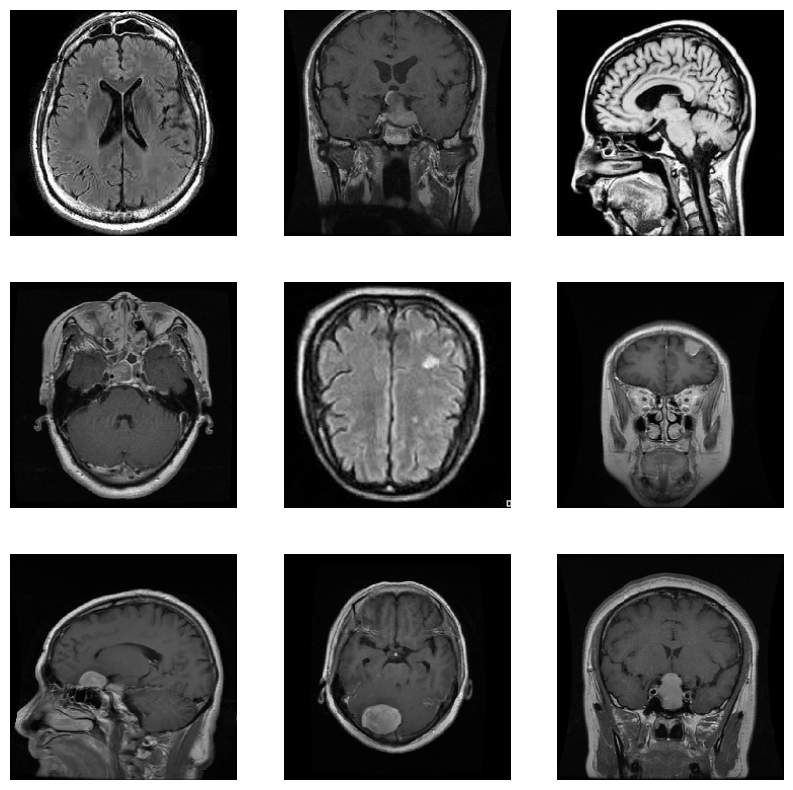

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


original_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


original_generator = original_datagen.flow_from_directory(
    "dataset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)


for images, labels in original_generator:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    break



In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG19-specific preprocessing
    validation_split=0.2,
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom in or out on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in missing pixels using the nearest neighbor
)



test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
 )

In [ ]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',  # For multi-class classification
    shuffle=True
)

# validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',  # For multi-class classification
    shuffle=True
)


# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4577 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1432 images belonging to 4 classes.


In [ ]:

# Define the MobileNetV2-based model
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_mobilenet_model():
    mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in mobilenet_base.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False
    model = Sequential([
        mobilenet_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = create_mobilenet_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
 monitor='val_loss',
 factor=0.5,
 patience=3,
 min_lr=1e-6,
 verbose=1
)

# Callbacks
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Train the model using the same training setup
History_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_monitor, lr_scheduler]
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 603ms/step - accuracy: 0.4472 - loss: 11.7939 - val_accuracy: 0.7203 - val_loss: 10.4914 - learning_rate: 1.0000e-04
Epoch 2/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 110s 474ms/step - accuracy: 0.7762 - loss: 10.2981 - val_accuracy: 0.7526 - val_loss: 9.8816 - learning_rate: 1.0000e-04
Epoch 3/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 470ms/step - accuracy: 0.8403 - loss: 9.5111 - val_accuracy: 0.8400 - val_loss: 9.0648 - learning_rate: 1.0000e-04
Epoch 4/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 472ms/step - accuracy: 0.8780 - loss: 8.7882 - val_accuracy: 0.8767 - val_loss: 8.2950 - learning_rate: 1.0000e-04
Epoch 5/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 471ms/step - accuracy: 0.8916 - loss: 8.0684 - val_accuracy: 0.8925 - val_loss: 7.6142 - learning_rate: 1.0000e-04
Epoch 6/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 469ms/step - accuracy: 0.9147 - loss: 7.3647 - val_accuracy: 0.9152 - val_loss: 6.8745 - learning_rate: 1.0000e-04
Epoch 7/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 474ms/st

In [ ]:

# Evaluate the MobileNet model
test_loss, test_acc = mobilenet_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"MobileNet Test Accuracy: {test_acc:.2f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9732 - loss: 0.2558
MobileNet Test Accuracy: 0.98


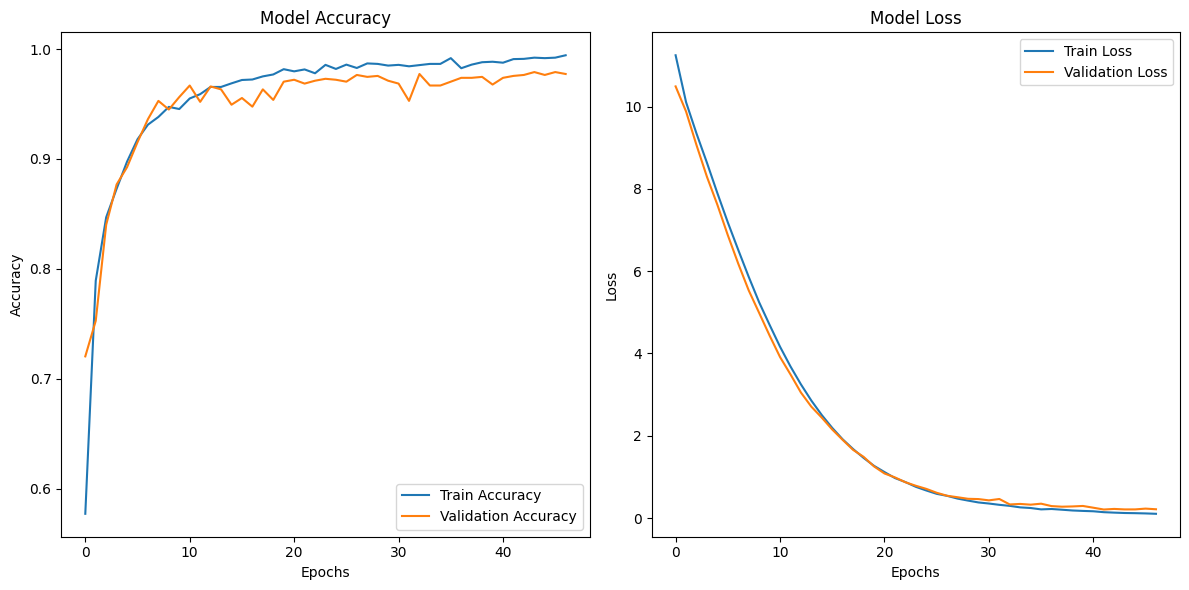

In [ ]:
history = History_mobilenet.history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
final_train_acc = History_mobilenet.history['accuracy'][-1]
final_val_acc = History_mobilenet.history['val_accuracy'][-1]
final_train_loss = History_mobilenet.history['loss'][-1]
final_val_loss = History_mobilenet.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9943
Final Validation Accuracy: 0.9773
Final Training Loss: 0.1037
Final Validation Loss: 0.2139


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step


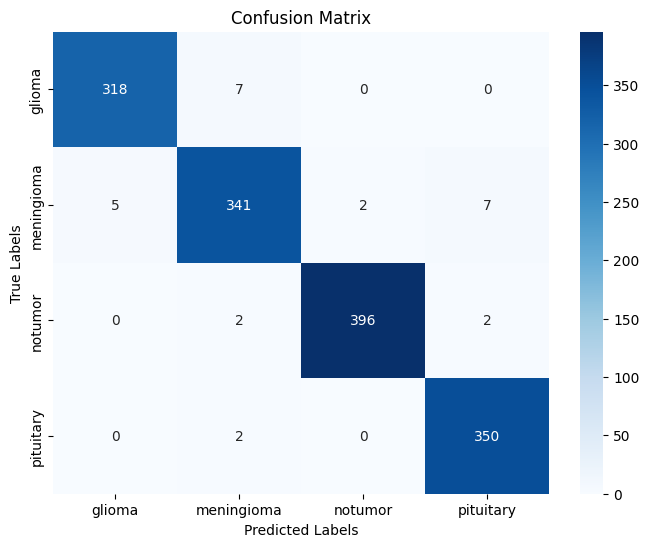

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 5. Confusion Matrix
y_true = test_generator.classes
y_pred = np.argmax(mobilenet_model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()




In [ ]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       325
  meningioma       0.97      0.96      0.96       355
     notumor       0.99      0.99      0.99       400
   pituitary       0.97      0.99      0.98       352

    accuracy                           0.98      1432
   macro avg       0.98      0.98      0.98      1432
weighted avg       0.98      0.98      0.98      1432



In [ ]:
train_files = train_generator.filenames
test_files = test_generator.filenames

# Check for common filenames
overlap = set(train_files).intersection(set(test_files))
print(f"Number of overlapping files: {len(overlap)}")
if overlap:
    print("Data leakage detected!")
else:
    print("No data leakage.")


Number of overlapping files: 0
No data leakage.
